In [3]:
import os
os.chdir("../../../")

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import surgeon

Using TensorFlow backend.
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohsen/miniconda3

In [5]:
sc.set_figure_params(dpi=200)

In [6]:
data_name = "pbmc_panorama"
dataset_key = "study"
condition_key = "condition"
cell_type_key = "cell_type"
target_datasets = ["PBMC Kang - control", "PBMC Kang - stimulated"]

In [7]:
adata = sc.read(f"./data/{data_name}/{data_name}_normalized_hvg.h5ad")
adata

AnnData object with n_obs × n_vars = 58207 × 2000 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [8]:
adata.obs[dataset_key].value_counts()

PBMC 10X - control        26202
PBMC 68K - control        18006
PBMC Kang - stimulated     7451
PBMC Kang - control        6548
Name: study, dtype: int64

In [9]:
adata.obs.groupby([dataset_key, cell_type_key]).size()

study                   cell_type
PBMC 10X - control      B             2488
                        CD4 T        10706
                        CD8 T         3990
                        CD14 Mono      873
                        NK            6659
                        T             1486
PBMC 68K - control      B              896
                        CD14 Mono     1501
                        NK             319
                        T            15290
PBMC Kang - control     B              592
                        CD4 T         1837
                        CD8 T          352
                        CD14 Mono     2215
                        CD16 Mono      507
                        DC             258
                        Eryth           23
                        Mk             115
                        NK             298
                        T              300
                        pDC             51
PBMC Kang - stimulated  B              774
                    

In [10]:
adata.X.min(), adata.X.max()

(0.0, 6.146675)

In [11]:
adata_for_training = adata[~adata.obs[dataset_key].isin(target_datasets)]
adata_out_of_sample = adata[adata.obs[dataset_key].isin(target_datasets)]

In [12]:
adata_for_training.obs[dataset_key].value_counts()

PBMC 68K - control     18006
PBMC Kang - control     6548
Name: study, dtype: int64

In [13]:
n_datasets = len(adata_for_training.obs[dataset_key].unique().tolist())
n_datasets

2

In [14]:
network = surgeon.archs.CVAE(x_dimension=adata_for_training.shape[1],
                             z_dimension=5,
                             architecture=[128, 32, 16, 8],
                             n_conditions=n_datasets,
                             alpha=0.0005,
                             beta=100,
                             eta=1,
                             loss_fn='mse',
                             clip_value=1000,
                             lambda_l2=0.0,
                             output_activation='relu',
                             use_batchnorm=False,
                             dropout_rate=0.05,
                             model_path=f"./models/CVAE/Perturbation/{data_name}/before/",
                             print_summary=False
                            )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
datasets = adata_for_training.obs[dataset_key].unique().tolist()
dataset_encoder = surgeon.utils.create_dictionary(datasets, [])

In [16]:
dataset_encoder

{'PBMC Kang - control': 0, 'PBMC 68K - control': 1}

In [17]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.80)

In [18]:
network.model_path = "./models/test/"

In [ ]:
network.train(train_adata,
              valid_adata,
              condition_key=dataset_key,
              le=dataset_encoder,
              n_epochs=1000,
              batch_size=1024,
              early_stop_limit=50,
              lr_reducer=40,
              n_per_epoch=0,
              save=True,
              retrain=True,
              verbose=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000:
 - loss: 108.4468 - kl_sse_loss: 105.9055 - mmd_loss: 2.5413 - val_loss: 91.7050 - val_kl_sse_loss: 90.9796 - val_mmd_loss: 0.7254
Epoch 51/1000:
 - loss: 41.6875 - kl_sse_loss: 41.0301 - mmd_loss: 0.6575 - val_loss: 41.5672 - val_kl_sse_loss: 40.6005 - val_mmd_loss: 0.9667
Epoch 101/1000:
 - loss: 39.3056 - kl_sse_loss: 38.8340 - mmd_loss: 0.4716 - val_loss: 38.5263 - val_kl_sse_loss: 37.9266 - val_mmd_loss: 0.5997
Epoch 151/1000:
 - loss: 38.4419 - kl_sse_loss: 38.0320 - mmd_loss: 0.4099 - val_loss: 37.5267 - val_kl_sse_loss: 37.0270 - val_mmd_loss: 0.4997
Epoch 201/1000:
 - loss: 37.8755 - kl_sse_loss: 37.5454 - mmd_loss: 0.3301 - val_loss: 37.1072 - val_kl_sse_loss: 36.7225 - val_mmd_loss: 0.3846
Epoch 251/1000:
 - loss: 37.5501 - kl_sse_loss: 37.2380 - mmd_loss: 0.3120 - val_loss: 36.7546 - val_kl_sse_loss: 36.3745 - val_mmd_loss: 0.3800
Epoch 301/1000:
 - loss: 37.2721 - kl_sse_loss: 36.9501 - mmd_loss: 0.3221 - val_lo

In [19]:
encoder_datasets, _ = surgeon.utils.label_encoder(adata_for_training, label_encoder=network.condition_encoder,
                                                        condition_key=dataset_key)

In [20]:
latent_adata = network.to_mmd_layer(adata_for_training, encoder_datasets, encoder_datasets)
latent_adata

AnnData object with n_obs × n_vars = 44208 × 6 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'

In [21]:
sc.settings.set_figure_params(dpi=200)

In [22]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


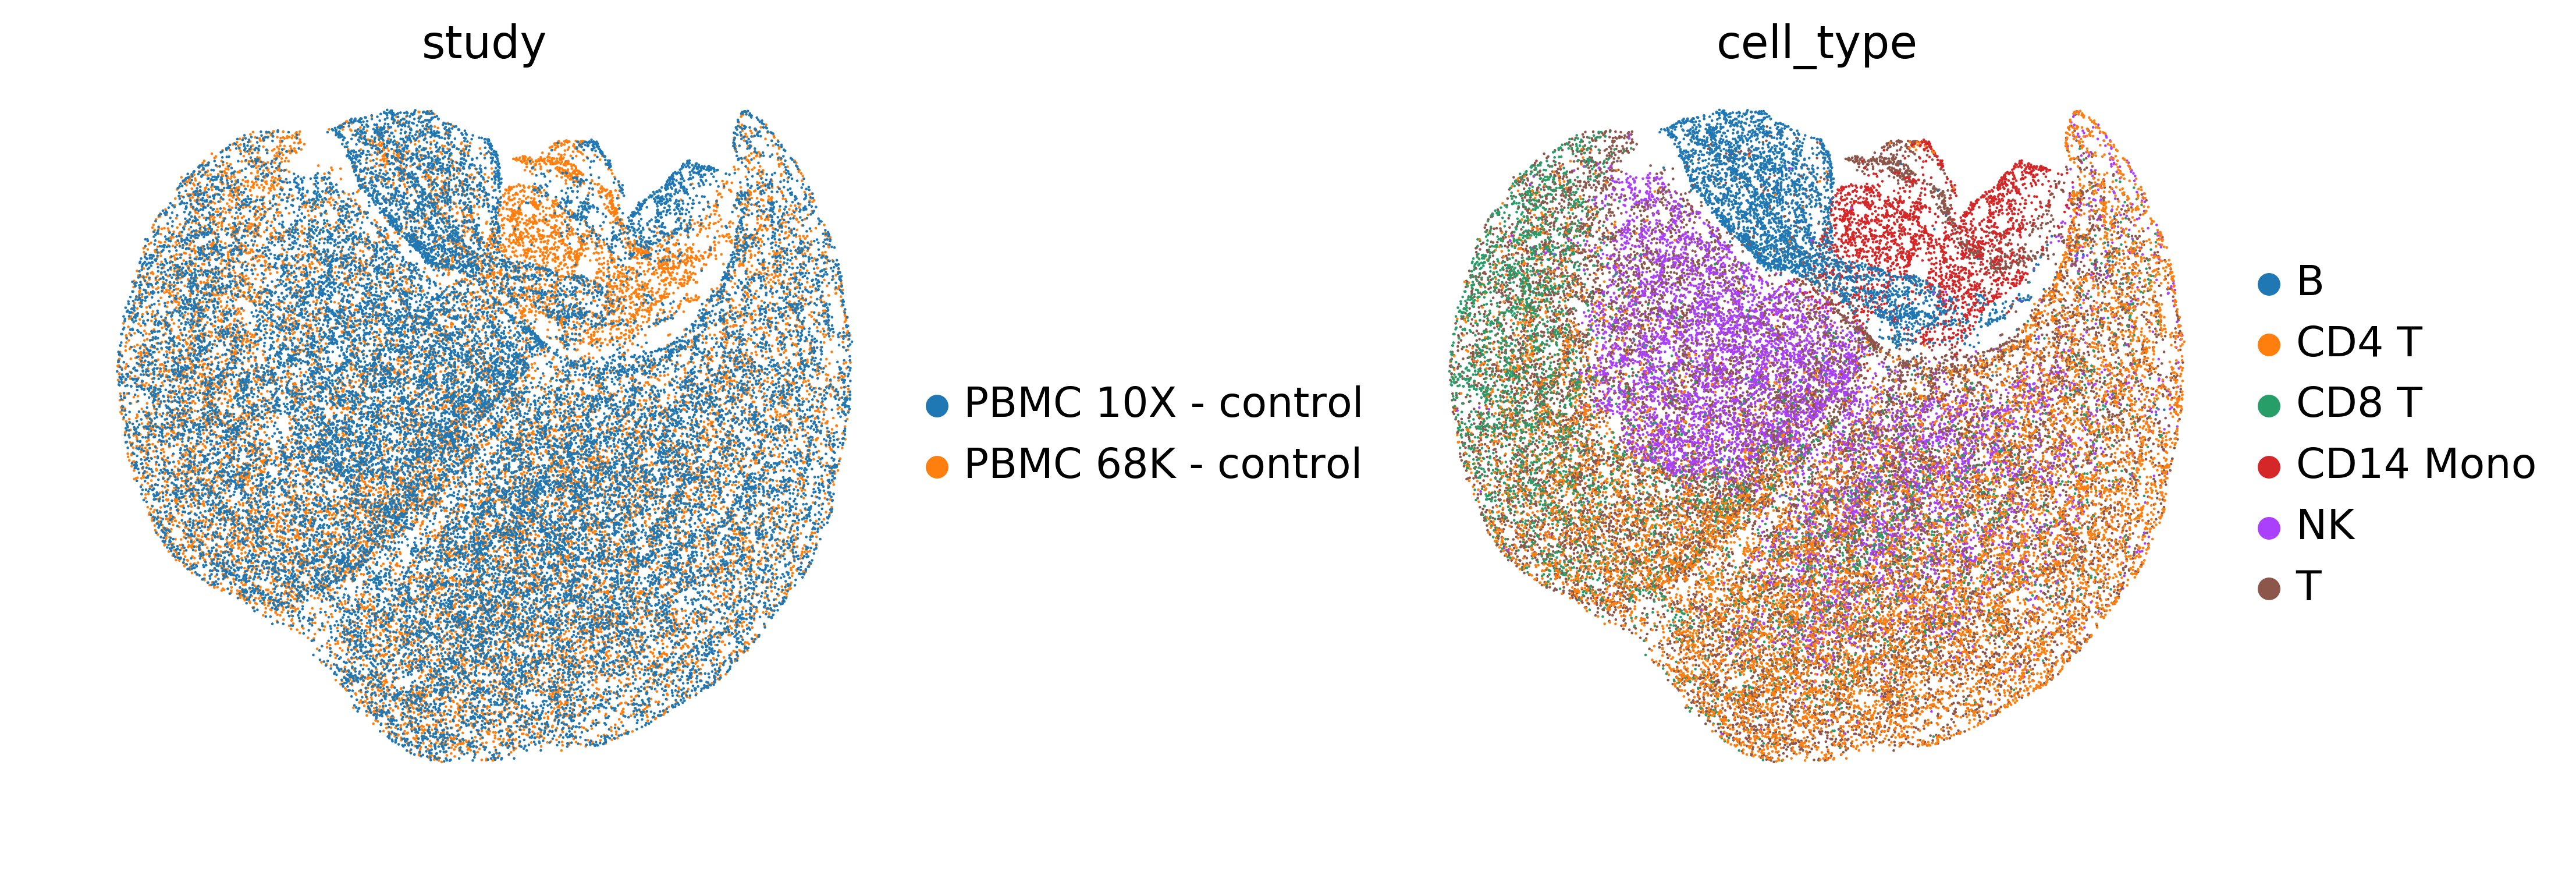

In [23]:
sc.pl.umap(latent_adata, color=[dataset_key, cell_type_key], 
           wspace=0.5, frameon=False, save=None)

In [ ]:
new_network = surgeon.operate(network,
                              new_conditions=target_datasets,
                              freeze=True,
                              freeze_expression_input=True,
                              remove_dropout=False,
                              new_training_kwargs={"beta": 100,
                                                   "eta":0.00001,},
                              )

In [ ]:
new_network.model_path = f"./models/CVAE/Perturbation/{data_name}/after/"

In [ ]:
new_network.condition_encoder

In [ ]:
adata_out_of_sample.obs[dataset_key].value_counts()

In [ ]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.80)

In [ ]:
train_adata.shape, valid_adata.shape

In [ ]:
new_network.train(train_adata,
                  valid_adata,
                  condition_key=dataset_key,
                  le=new_network.condition_encoder,
                  n_epochs=1000,
                  batch_size=1024,
                  early_stop_limit=50,
                  lr_reducer=40,
                  n_per_epoch=0,
                  save=True,
                  retrain=True,
                  verbose=50)

In [ ]:
new_network.condition_encoder

In [ ]:
encoder_datasets, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder,
                                                        condition_key=dataset_key)
encoder_datasets.shape

In [ ]:
latent_adata = new_network.to_mmd_layer(adata_out_of_sample, encoder_datasets, encoder_datasets)
latent_adata

In [ ]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [ ]:
sc.pl.umap(latent_adata, color=[dataset_key, cell_type_key], 
           wspace=0.5, frameon=False, save=None)

In [ ]:
encoder_datasets, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder,
                                                        condition_key=dataset_key)
encoder_datasets.shape

In [ ]:
latent_adata = new_network.to_mmd_layer(adata, encoder_datasets, encoder_datasets)

In [ ]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [ ]:
sc.pl.umap(latent_adata, color=[dataset_key, cell_type_key], 
           wspace=0.7, frameon=False, save=None)